In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Using the built-in IMDb dataset from Keras for simplicity
from tensorflow.keras.datasets import imdb

max_features = 10000
This parameter limits the vocabulary size to the 10,000 most frequent words in the dataset. Words that aren't in the top 10,000 will be treated as unknown (usually represented by a special token like <UNK>).
maxlen = 200
This parameter sets the maximum length (in words/tokens) for each review. Reviews longer than 200 words will be truncated, and shorter ones will be padded.


In [5]:
# Define parameters
max_features = 10000  # Consider only the top 10,000 words
maxlen = 200  # Cut texts after 200 words

In [6]:
print("Loading data...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(f"Loaded {len(x_train)} training examples and {len(x_test)} testing examples")

Loading data...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Loaded 25000 training examples and 25000 testing examples


In [9]:
# Get the word index mapping
word_index = imdb.get_word_index()

# Reverse the word index to get words from indices
reverse_word_index = {value: key for key, value in word_index.items()}


In [10]:
reverse_word_index

{34701: 'fawn',
 52006: 'tsukino',
 52007: 'nunnery',
 16816: 'sonja',
 63951: 'vani',
 1408: 'woods',
 16115: 'spiders',
 2345: 'hanging',
 2289: 'woody',
 52008: 'trawling',
 52009: "hold's",
 11307: 'comically',
 40830: 'localized',
 30568: 'disobeying',
 52010: "'royale",
 40831: "harpo's",
 52011: 'canet',
 19313: 'aileen',
 52012: 'acurately',
 52013: "diplomat's",
 25242: 'rickman',
 6746: 'arranged',
 52014: 'rumbustious',
 52015: 'familiarness',
 52016: "spider'",
 68804: 'hahahah',
 52017: "wood'",
 40833: 'transvestism',
 34702: "hangin'",
 2338: 'bringing',
 40834: 'seamier',
 34703: 'wooded',
 52018: 'bravora',
 16817: 'grueling',
 1636: 'wooden',
 16818: 'wednesday',
 52019: "'prix",
 34704: 'altagracia',
 52020: 'circuitry',
 11585: 'crotch',
 57766: 'busybody',
 52021: "tart'n'tangy",
 14129: 'burgade',
 52023: 'thrace',
 11038: "tom's",
 52025: 'snuggles',
 29114: 'francesco',
 52027: 'complainers',
 52125: 'templarios',
 40835: '272',
 52028: '273',
 52130: 'zaniacs',

In [8]:
# Function to convert sequences back to text (for exploration)
def sequence_to_text(sequence):
    # The indices are offset by 3 in the IMDb dataset
    # Index 0: padding, 1: start of sequence, 2: unknown
    return ' '.join([reverse_word_index.get(i-3, '?') for i in sequence])

In [11]:
# Print a few examples
print("\nSample review:")
print(sequence_to_text(x_train[0]))
print(f"Sentiment: {'Positive' if y_train[0] == 1 else 'Negative'}")


Sample review:
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have do

In [12]:
# 2. Preprocess the Data
# ======================
# Pad sequences to ensure uniform length
print("\nPadding sequences...")
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")


Padding sequences...
x_train shape: (25000, 200)
x_test shape: (25000, 200)


In [13]:
# Create validation set from training data
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)
print(f"Training samples: {x_train.shape[0]}")
print(f"Validation samples: {x_val.shape[0]}")
print(f"Testing samples: {x_test.shape[0]}")

Training samples: 20000
Validation samples: 5000
Testing samples: 25000


In [14]:
# 3. Build the Bi-Directional LSTM Model
# =====================================
print("\nBuilding model...")

model = Sequential()
# Embedding layer
model.add(Embedding(max_features, 128, input_length=maxlen))
# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))




Building model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Option 1: Explicitly build the model
model.build(input_shape=(None, maxlen))


# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,424,257 (5.43 MB)

 Trainable params: 1,424,257 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 4. Train the Model
# =================
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [17]:
model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

In [18]:
# Train the model
print("\nTraining model...")
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)


Training model...
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6649 - loss: 0.5810

157/157 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.6656 - loss: 0.5803 - val_accuracy: 0.8524 - val_loss: 0.3440
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8853 - loss: 0.2915

157/157 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.8854 - loss: 0.2913 - val_accuracy: 0.8818 - val_loss: 0.2999
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.9199 - loss: 0.2123 - val_accuracy: 0.8316 - val_loss: 0.5369
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.9275 - loss: 0.1882 - val_accuracy: 0.8334 - val_loss: 0.4324
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.9537 - loss: 0.1310 - val_accuracy: 0.7534 - val_loss: 0.7120


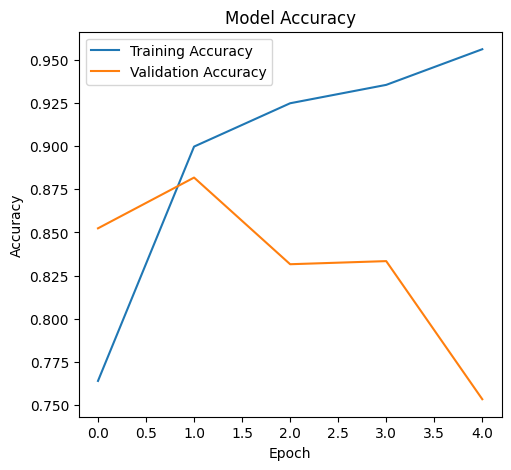

In [20]:
# 5. Evaluate the Model
# ====================
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [21]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.close()

In [22]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions on test set
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Evaluating on test set...
782/782 ━━━━━━━━━━━━━━━━━━━━ 85s 107ms/step - accuracy: 0.8694 - loss: 0.3185
Test accuracy: 0.8712
Test loss: 0.3168
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.88      0.87     12500
    Positive       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [23]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.close()

In [24]:
# 6. Function to Predict Sentiment for New Reviews
# ================================================
def predict_sentiment(review_text):
    # Convert to sequence
    sequence = []
    for word in review_text.lower().split():
        if word in word_index:
            # Offset by 3 as in the IMDb dataset
            sequence.append(word_index[word] + 3)

    # Pad sequence
    padded_sequence = pad_sequences([sequence], maxlen=maxlen)

    # Predict
    prediction = model.predict(padded_sequence)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return sentiment, confidence

In [25]:
# Test the prediction function with a new review
new_review = "This movie was fantastic! The acting was great and the plot was engaging throughout."
sentiment, confidence = predict_sentiment(new_review)
print(f"\nSample prediction:")
print(f"Review: {new_review}")
print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.4f})")

# Another example with a negative review
new_review = "I was really disappointed with this film. The characters were poorly developed and the story made no sense."
sentiment, confidence = predict_sentiment(new_review)
print(f"\nReview: {new_review}")
print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

Sample prediction:
Review: This movie was fantastic! The acting was great and the plot was engaging throughout.
Predicted sentiment: Negative (confidence: 0.5531)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

Review: I was really disappointed with this film. The characters were poorly developed and the story made no sense.
Predicted sentiment: Negative (confidence: 0.8955)
